# Kalman Filter를 이용한 Raw RSSI Data 필터링 실험

송신기와 수신기 사이의 거리, 전력 세기뿐만이 아니라 채널 간섭, 환경 요인 등으로 Anchor Point (AP)에 수신되는 RSSI 값이 일정한 값이 아닌 분산이 큰 형태로, 즉 노이즈가 추가된 형태로 수신되는 문제점을 발견했다.

따라서 분산이 큰 해당 RSSI 값들로 우리의 BLE 장치의 RSSI 이상치 값의 범위를 설정하게 되면 과도하게 큰 기준 범위가 생성된다.

그러므로 분산이 큰 형태로 수신되는 RSSI 값들을 노이즈 제거에 효과적이고 지속적으로 변화하는 RSSI 값에 이상적인 Kalman Filter를 이용해 필터 작업을 수행한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Kalman Filter
class KalmanFilter():
    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI
    
kf = KalmanFilter(processNoise=0.0005,measurementNoise=20)

### Data
* Anchor Point (AP)로부터 일정한 거리에 떨어진 지점에서 정상 BLE 장치의 비콘 메시지 수집
* 약 10000 개의 데이터 수집

### Progress
* Anchor Point (AP)에 수신되는 Raw RSSI 값들의 분산도를 계산
* 또한 평균값으로부터 얼마나 벗어나있는지 그래프로 확인
* 이후 Kalman Filter를 적용한 Filtered RSSI 값들의 분산도를 계산
* 마찬가지로 평균값으로부터 얼마나 벗어나있는지 그래프로 확인

In [3]:
# Read Data Files
df = []
df_rssi = []
files = []

for i in range(1,9):
    file = './data/rssi_data_' + str(i) + '.csv'
    
    tmp = pd.read_csv(file)
    tmp_rssi = tmp['rssi']
    
    df.append(tmp)
    df_rssi.append(tmp_rssi)
    files.append("File " + str(i))
    
    print('-'*50)
    print("File :", file)
    print("Number of Beacon Message :", tmp.shape[0])
    print("Average RSSI :", np.mean(tmp_rssi))

--------------------------------------------------
File : ./data/rssi_data_1.csv
Number of Beacon Message : 2090
Average RSSI : -42.264593301435404
--------------------------------------------------
File : ./data/rssi_data_2.csv
Number of Beacon Message : 2118
Average RSSI : -55.622285174693104
--------------------------------------------------
File : ./data/rssi_data_3.csv
Number of Beacon Message : 2031
Average RSSI : -58.61447562776957
--------------------------------------------------
File : ./data/rssi_data_4.csv
Number of Beacon Message : 2301
Average RSSI : -53.97175141242938
--------------------------------------------------
File : ./data/rssi_data_5.csv
Number of Beacon Message : 552
Average RSSI : -37.6231884057971
--------------------------------------------------
File : ./data/rssi_data_6.csv
Number of Beacon Message : 486
Average RSSI : -70.440329218107
--------------------------------------------------
File : ./data/rssi_data_7.csv
Number of Beacon Message : 399
Average R

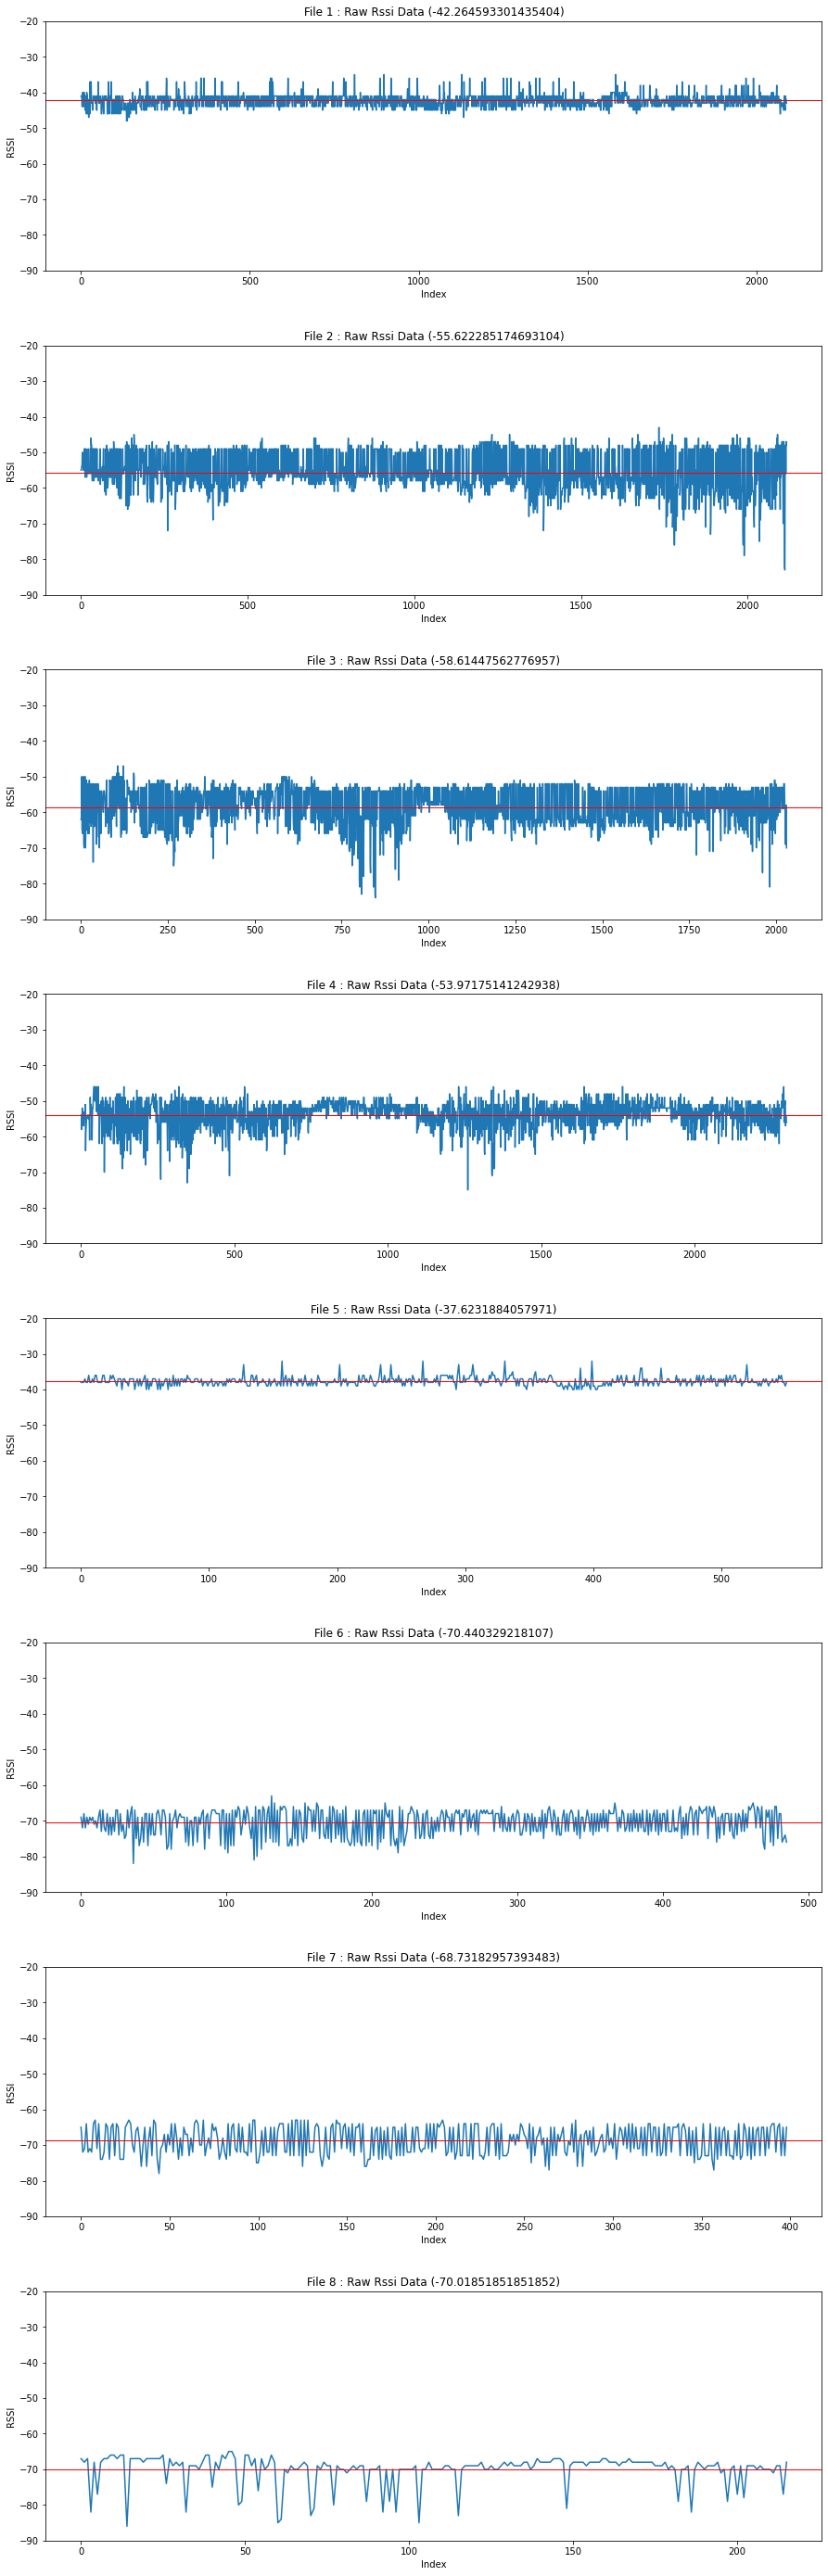

In [4]:
# Show Raw RSSI Data
f, axes = plt.subplots(8,1)
f.set_size_inches((15, 50))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(8):
    # Show Graph
    axes[i].plot(df_rssi[i])
    axes[i].axhline(y=np.mean(df_rssi[i]), color='r', linewidth=1)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('RSSI')
    axes[i].set_ylim(-90,-20)
    axes[i].set_title('File ' + str(i+1) + ' : Raw Rssi Data (' + str(np.mean(df_rssi[i])) + ')')
    
plt.show()

In [5]:
df_rssi_kf = []

for i in range(8):
    tmp_kf = KalmanFilter(processNoise=0.0005,measurementNoise=20)
    tmp_rssi_kf = []
    
    for d in df_rssi[i]:
        tmp_rssi_kf.append(tmp_kf.applyFilter(rssi = d))
        
    df_rssi_kf.append(tmp_rssi_kf)

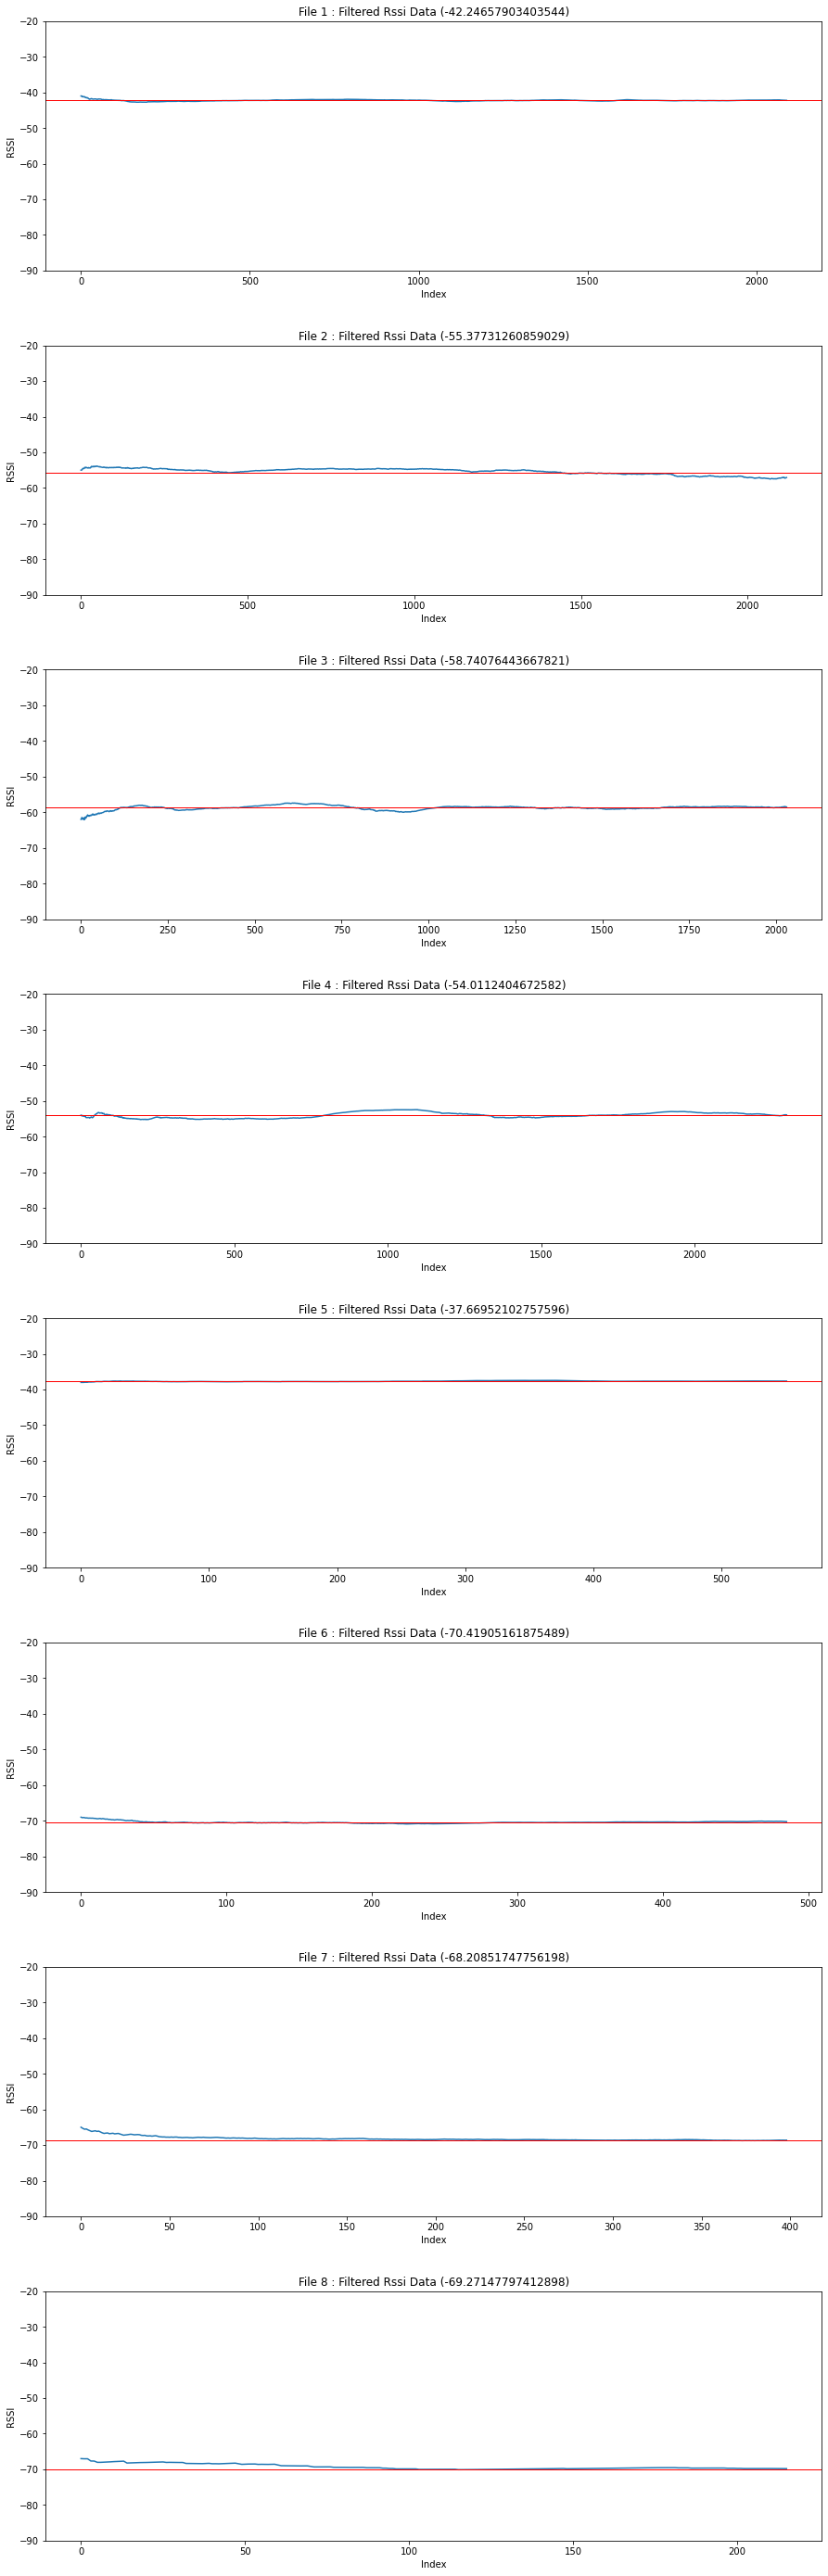

In [6]:
# Show Filtered RSSI Data
f, axes = plt.subplots(8,1)
f.set_size_inches((15, 50))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(8):
    # Show Graph
    axes[i].plot(df_rssi_kf[i])
    axes[i].axhline(y=np.mean(df_rssi[i]), color='r', linewidth=1)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('RSSI')
    axes[i].set_ylim(-90,-20)
    axes[i].set_title('File ' + str(i+1) + ' : Filtered Rssi Data (' + str(np.mean(df_rssi_kf[i])) + ')')
    
plt.show()

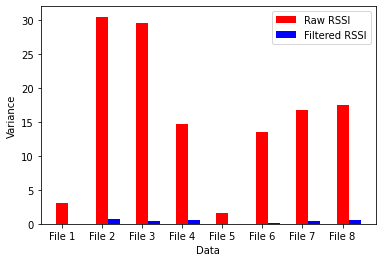

In [7]:
# Compare Variance
df_rssi_vs = []
df_rssi_kf_vs = []

for i in range(8):
    df_rssi_vs.append(np.var(df_rssi[i]))
    df_rssi_kf_vs.append(np.var(df_rssi_kf[i]))

x = np.arange(len(files))

plt.bar(x, df_rssi_vs, label = 'Raw RSSI', width = 0.3, color = 'red')
plt.bar(x+0.3, df_rssi_kf_vs, label = 'Filtered RSSI', width = 0.3, color = 'blue')
plt.xticks(x, files)
plt.legend()
plt.xlabel('Data')
plt.ylabel('Variance')

plt.show()